# Introduction

> In this project, we consider the problem about finding the best location of a new 7-11 franchisee based on existing 7-11 locations and residential buildings (population).

> We will introduce 4 methods to solve this problem.

## Env

> pip install pandana osmnx geopandas notebook

In [19]:
import time
import random

import osmnx as ox
import numpy as np
import geopandas as gpd
import pandana
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

# Method A

In this method, we use K-means algorithm to decide the 711 that buildings belongs to. After that, we will find the most cost 711. In this 711, the sum of shortest path between it and buildings belong to it is the largest one. That means people in these buildings are most inconvenient. Thus, we open a new 711 in this area. The location will be refined by k-means.


In [20]:
def extract_graph(place):
    ox.config(log_console=True, use_cache=True)
    G = ox.graph_from_place(place, network_type='drive')
    return G
    
def extract_seven_elevens_buildings(place):
    ox.config(log_console=True, use_cache=True)
    
    # we only interested in building names and it's geometric information
    tags = {'building': ['residential']}
    all_buildings = ox.geometries_from_place(place, tags=tags)
    all_buildings = all_buildings[['name','geometry']]
    all_buildings = all_buildings[~(all_buildings['name'].isnull())]
    all_buildings = all_buildings[~(all_buildings['geometry'].isnull())]
    all_buildings['center'] = gpd.points_from_xy(x= all_buildings['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_buildings['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_buildings))
#     print("*"*50, all_buildings)
    
    tags = {'name': ['7-Eleven']}
    all_seven_elevens = ox.geometries_from_place(place, tags=tags)
    all_seven_elevens = all_seven_elevens[~(all_seven_elevens['name'].isnull())]
    all_seven_elevens = all_seven_elevens[~(all_seven_elevens['geometry'].isnull())]
    all_seven_elevens['center'] = gpd.points_from_xy(x= all_seven_elevens['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_seven_elevens['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_seven_elevens))
#     print("*"*50, all_seven_elevens)
    return all_seven_elevens,all_buildings

In [21]:
def get_seven_elevens_buildings(place):
    G = extract_graph(place)
    all_seven_elevens,all_buildings = extract_seven_elevens_buildings(place)

    # print("."*50, all_seven_elevens)
    node_seven_elevens  = ox.distance.nearest_nodes(G,X=all_seven_elevens['center'].x,Y = all_seven_elevens['center'].y)
    # print("/"*50, node_seven_elevens)

    # print("."*50, all_buildings)
    node_buildings  = ox.distance.nearest_nodes(G,X=all_buildings['center'].x,Y = all_buildings['center'].y)
    # print("/"*50, node_buildings)
    return G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings

In [4]:
def plot_seven_elevens_buildings(G, all_seven_elevens,all_buildings):
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    ax.scatter(all_seven_elevens['center'].x,   all_seven_elevens['center'].y,   c='g',    marker="s",alpha=1,zorder=4)
    ax.scatter(all_buildings['center'].x, all_buildings['center'].y, c='blue',            alpha=1,zorder=3)

In [5]:
def one_epoch(G, node_seven_elevens, node_buildings, learn_last=False, node_new=0):
    if not learn_last:
        K = len(node_seven_elevens)
    else:
        K = len(node_seven_elevens) + 1
    dist = np.zeros(K)
    number = np.zeros(K)
    neighbors = [[] for i in range(0, K)]
    for n, neighbor in enumerate(node_buildings):
        cloest_l = -1
        cloest_k = -1
        for k in range(0, K):
            if not learn_last or k < K - 1:
                center = node_seven_elevens[k]
            else:
                center = node_new
            # print("K, N", k, center)
            if nx.has_path(G, neighbor, center) and nx.has_path(G, center, neighbor):
                l = nx.shortest_path_length(G, source=neighbor, target=center)
                if cloest_k == -1 or l < cloest_l:
                    cloest_k = k
                    cloest_l = l
        if cloest_k != -1:
            # dist
            dist[cloest_k] += cloest_l
            # number
            number[cloest_k] += 1
            # neighbors
            neighbors[cloest_k].append(n)        
    return dist, number, neighbors

In [6]:
def Find711(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings):
    # prepare training
    num_K = len(all_seven_elevens)+1
    num_N = len(all_buildings)
    print("num_K:", num_K)
    print("num_N:", num_N)
    node_new = node_buildings[random.randint(0, len(node_buildings) - 1)]
    print("node_new", node_new)
    
    # training
    decided = False
    for i in range(5):
        dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings, learn_last=True, node_new=node_new)
        avg_dist = (dist+0) / (number+1)  # include self
        print("len(dist), dist.mean()", len(dist[number != 0]), dist[number != 0].mean())    
        print("avg_dist max", np.argmax(avg_dist), avg_dist.max())

        # check whether new location is effective
        neighbors_new = neighbors[-1]
        dist_new = dist[-1]
        avg_dist_new = avg_dist[-1]
        number_new = number[-1]
        print("dist_new avg_dist_new number_new", dist_new, avg_dist_new, number_new)
        # if len(neighbors_new) == 0:
        if not decided:
            decided = True
            print("*"*50)
            # if have not got an effective new location for 711, we locate it near by the most busy 711
            neighbors_busy = neighbors[np.argmax(avg_dist)]
            neighbor_new = neighbors_busy[random.randint(0, len(neighbors_busy) - 1)]
            node_new_x = all_buildings['center'][neighbor_new].x
            node_new_y = all_buildings['center'][neighbor_new].y
            node_new = node_buildings[neighbor_new]
        else:
            print("-"*50)
            # if have got an effective new location for 711, we refine its location by k means
            node_new_x = np.mean(all_buildings['center'][neighbors_new].x)
            node_new_y = np.mean(all_buildings['center'][neighbors_new].y)
            node_new = ox.distance.nearest_nodes(G,X=node_new_x,Y=node_new_y)
        print("node_new", node_new)
        
    # visulization
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    ax.scatter(
        node_new_x,   
        node_new_y,   
        c='g',    
        marker="s",
        alpha=1,
        zorder=4
    )
    ax.scatter(
        all_buildings['center'][neighbors[num_K -1]].x, 
        all_buildings['center'][neighbors[num_K -1]].y, 
        c='blue',            
        alpha=1,
        zorder=3
    )
    return node_new, node_new_x, node_new_y

In [7]:
import time
def Build711MethodA(place='Macau'):
    # get data
    G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings = get_seven_elevens_buildings(place)
    plot_seven_elevens_buildings(G, all_seven_elevens,all_buildings)
    
    start_time = time.time()
    node_new, node_new_x, node_new_y = Find711(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings)
    end_time = time.time()

    # metric
    print("-"*50, node_seven_elevens)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("before: total dist", np.sum(dist))
    node_seven_elevens.append(node_new)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("after total dist", np.sum(dist))
    print("Time cost", end_time - start_time)

2022-05-21 00:26:26 Configured OSMnx 1.1.2
2022-05-21 00:26:26 HTTP response caching is on
2022-05-21 00:26:26 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-21 00:26:26 Created GeoDataFrame with 1 rows from 1 queries
2022-05-21 00:26:26 Constructed place geometry polygon(s) to query API
2022-05-21 00:26:26 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:26:26 Projected GeoDataFrame to epsg:4326
2022-05-21 00:26:26 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:26:26 Projected GeoDataFrame to epsg:4326
2022-05-21 00:26:26 Requesting data within polygon from API in 1 request(s)


/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:26:26 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-21 00:26:26 Got all network data within polygon from API in 1 request(s)
2022-05-21 00:26:26 Creating graph from downloaded OSM data...
2022-05-21 00:26:26 Created graph with 23498 nodes and 29564 edges
2022-05-21 00:26:26 Added length attributes to graph edges
2022-05-21 00:26:26 Identifying all nodes that lie outside the polygon...
2022-05-21 00:26:27 Created nodes GeoDataFrame from graph
2022-05-21 00:26:27 Created r-tree spatial index for 23498 geometries
2022-05-21 00:26:27 Identified 22820 geometries inside polygon
2022-05-21 00:26:27 Removed 678 nodes outside polygon
2022-05-21 00:26:27 Truncated graph by polygon
2022-05-21 00:26:28 Begin topologically simplifying the graph...
2022-05-21 00:26:28 Identified 3456 edge endpoints
2022-05-21 00:26:28 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-21 00:26:28 Found 2 edges between 4208824304 a

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:26:29 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:26:29 Projected GeoDataFrame to epsg:4326
2022-05-21 00:26:29 Requesting data within polygon from API in 1 request(s)
2022-05-21 00:26:29 Retrieved response from cache file "cache/3208062aa142b9258b63ba1b19931f64befd9f55.json"
2022-05-21 00:26:29 Got all geometries data within polygon from API in 1 request(s)
2022-05-21 00:26:29 Converting 40 elements in JSON responses to geometries
2022-05-21 00:26:29 40 geometries created in the dict
2022-05-21 00:26:29 0 untagged geometries removed
2022-05-21 00:26:29 Created r-tree spatial index for 40 geometries
2022-05-21 00:26:29 Identified 40 geometries inside polygon
2022-05-21 00:26:29 0 geometries removed by the polygon filter
2022-05-21 00:26:29 0 geometries removed by the tag filter
2022-05-21 00:26:29 40 geometries in the final GeoDataFrame
2022-05-21 00:26:29 Created nodes GeoDataFrame from graph
2022-05-21

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:26:29 Created nodes GeoDataFrame from graph
2022-05-21 00:26:30 Finished plotting the graph
num_K: 41
num_N: 306
node_new 1944086367
len(dist), dist.mean() 39 61.82051282051282
avg_dist max 17 23.0
dist_new avg_dist_new number_new 8.0 1.1428571428571428 6.0
**************************************************
node_new 2492640216
len(dist), dist.mean() 38 54.76315789473684
avg_dist max 0 13.9
dist_new avg_dist_new number_new 43.0 2.5294117647058822 16.0
--------------------------------------------------
node_new 2492640188
2022-05-21 00:26:50 Created nodes GeoDataFrame from graph
len(dist), dist.mean() 38 55.078947368421055
avg_dist max 0 13.9
dist_new avg_dist_new number_new 55.0 3.235294117647059 16.0
--------------------------------------------------
2022-05-21 00:27:00 Created nodes GeoDataFrame from graph
node_new 2492640188
len(dist), dist.mean() 38 55.078947368421055
avg_dist max 0 13.9
dist_new avg_dist_new number_new 55.0 3.235294117647059 16.0
---------------------

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:27:21 Created nodes GeoDataFrame from graph
2022-05-21 00:27:21 Finished plotting the graph
-------------------------------------------------- [2169023906, 6040835453, 5543335567, 2157625970, 2027444154, 1793358410, 9004853901, 2486214926, 1867326940, 1846288224, 1754036977, 1758262871, 1754056425, 1754056421, 9519277096, 1754036975, 1937893684, 1941039624, 1942400761, 1942810205, 3536417231, 2168717760, 3121609540, 6308719038, 1846266736, 3121665344, 1942810197, 1449241485, 1449241483, 1846195341, 3355823826, 3109979756, 5105836446, 1809540500, 6361766988, 1942467224, 1937893685, 1754056408, 9026600201, 1938179570]
before: total dist 2429.0
after total dist 2093.0
Time cost 51.21206712722778


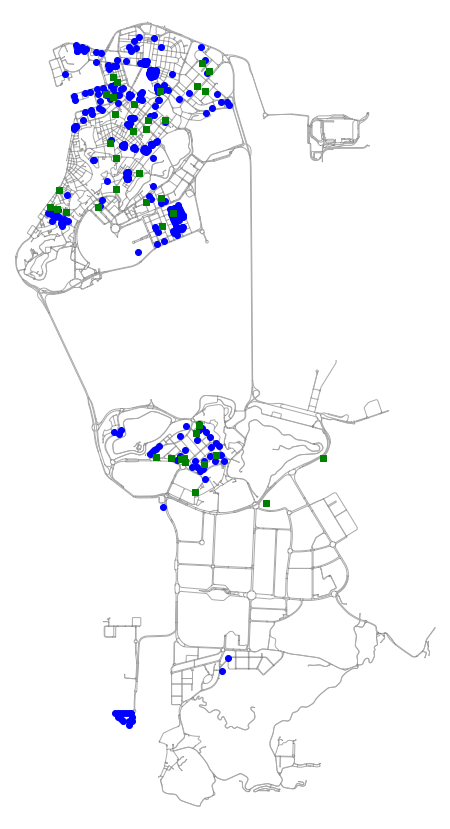

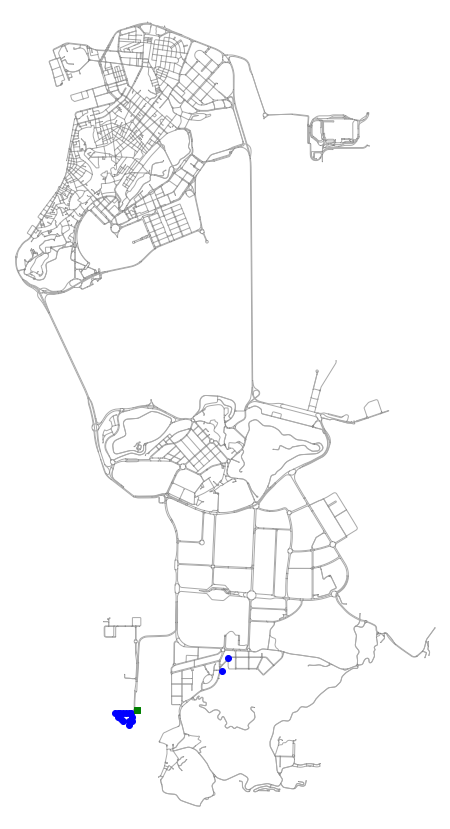

In [8]:
Build711MethodA(place='Macau')

# Method B

However, method A need to travel over all the buildings to calculate which 711 it belongs to. That means the complexity is O(NK), where N is the number of buildings and K is the number of 711s. However, number of N can be reduced. We filter out the buildings which are already besides a 711, and use the methodA algorithm in remains builds. This reduces complexity to O(kK)+O(nK), where k is the neighbor num and n << N.


In [9]:
from sklearn.neighbors import BallTree


In [10]:
import time
def Build711MethodB(place='Macau'):
    # get data
    G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings = get_seven_elevens_buildings(place)
    plot_seven_elevens_buildings(G, all_seven_elevens,all_buildings)

    start_time = time.time()
    
    # calculate buildings nearby 711
    filter_buildings = np.zeros(len(all_buildings))
    # Create tree from the candidate points    
    tree = BallTree(np.stack((all_buildings['center'].x, all_buildings['center'].y), axis=1), leaf_size=15, metric='haversine')
    # Find closest points and distances
    distances, indices = tree.query(np.stack((all_seven_elevens['center'].x, all_seven_elevens['center'].y), axis=1), k=5)  # distance from 711 to buildings
    for item in indices:
        filter_buildings[item] = 1
    #print("filter_buildings", filter_buildings)

    # filter out buildings nearby 711
    filtered_all_buildings = all_buildings[filter_buildings == 0]
    filtered_node_buildings = np.array(node_buildings)[filter_buildings == 0]
    
    # find 711
    node_new, node_new_x, node_new_y = Find711(G, all_seven_elevens, node_seven_elevens,filtered_all_buildings, filtered_node_buildings)

    end_time = time.time()

    # metric
    print("-"*50, node_seven_elevens)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("before: total dist", np.sum(dist))
    node_seven_elevens.append(node_new)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("after total dist", np.sum(dist))
    print("Time cost", end_time - start_time)

2022-05-21 00:27:41 Configured OSMnx 1.1.2
2022-05-21 00:27:41 HTTP response caching is on
2022-05-21 00:27:41 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-21 00:27:41 Created GeoDataFrame with 1 rows from 1 queries
2022-05-21 00:27:41 Constructed place geometry polygon(s) to query API
2022-05-21 00:27:41 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:27:41 Projected GeoDataFrame to epsg:4326
2022-05-21 00:27:41 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:27:41 Projected GeoDataFrame to epsg:4326
2022-05-21 00:27:41 Requesting data within polygon from API in 1 request(s)
2022-05-21 00:27:41 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-21 00:27:41 Got all network data within polygon from API in 1 request(s)
2022-05-21 00:27:41 Creating graph from downl

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:27:41 Created graph with 23498 nodes and 29564 edges
2022-05-21 00:27:42 Added length attributes to graph edges
2022-05-21 00:27:42 Identifying all nodes that lie outside the polygon...
2022-05-21 00:27:42 Created nodes GeoDataFrame from graph
2022-05-21 00:27:42 Created r-tree spatial index for 23498 geometries
2022-05-21 00:27:43 Identified 22820 geometries inside polygon
2022-05-21 00:27:43 Removed 678 nodes outside polygon
2022-05-21 00:27:43 Truncated graph by polygon
2022-05-21 00:27:43 Begin topologically simplifying the graph...
2022-05-21 00:27:43 Identified 3456 edge endpoints
2022-05-21 00:27:43 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-21 00:27:43 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-05-21 00:27:44 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-05-21 00:27:44 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-05-21 00:27:44 Found 2 edges between 1832146673

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:27:44 Created GeoDataFrame with 1 rows from 1 queries
2022-05-21 00:27:44 Constructed place geometry polygon(s) to query API
2022-05-21 00:27:44 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:27:44 Projected GeoDataFrame to epsg:4326
2022-05-21 00:27:44 Requesting data within polygon from API in 1 request(s)
2022-05-21 00:27:44 Retrieved response from cache file "cache/3208062aa142b9258b63ba1b19931f64befd9f55.json"
2022-05-21 00:27:44 Got all geometries data within polygon from API in 1 request(s)
2022-05-21 00:27:44 Converting 40 elements in JSON responses to geometries
2022-05-21 00:27:44 40 geometries created in the dict
2022-05-21 00:27:44 0 untagged geometries removed
2022-05-21 00:27:44 Created r-tree spatial index for 40 geometries
2022-05-21 00:27:44 Identified 40 geometries inside polygon
2022-05-21 00:27:44 0 geometries removed by the polygon filter
2022-05-21 00:27:44 0 geometries removed by the 

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:27:45 Created nodes GeoDataFrame from graph
2022-05-21 00:27:45 Finished plotting the graph
num_K: 41
num_N: 179
node_new 3122204363
len(dist), dist.mean() 22 68.18181818181819
avg_dist max 17 23.0
dist_new avg_dist_new number_new 185.0 4.3023255813953485 42.0
**************************************************
node_new 2492640216
len(dist), dist.mean() 21 72.0
avg_dist max 33 14.4
dist_new avg_dist_new number_new 43.0 2.5294117647058822 16.0
--------------------------------------------------
2022-05-21 00:27:57 Created nodes GeoDataFrame from graph
node_new 2492640188
len(dist), dist.mean() 21 72.57142857142857
avg_dist max 33 14.4
dist_new avg_dist_new number_new 55.0 3.235294117647059 16.0
--------------------------------------------------
node_new2022-05-21 00:28:03 Created nodes GeoDataFrame from graph
 2492640188
len(dist), dist.mean() 21 72.57142857142857
avg_dist max 33 14.4
dist_new avg_dist_new number_new 55.0 3.235294117647059 16.0
------------------------------

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:28:15 Created nodes GeoDataFrame from graph
2022-05-21 00:28:15 Finished plotting the graph
-------------------------------------------------- [2169023906, 6040835453, 5543335567, 2157625970, 2027444154, 1793358410, 9004853901, 2486214926, 1867326940, 1846288224, 1754036977, 1758262871, 1754056425, 1754056421, 9519277096, 1754036975, 1937893684, 1941039624, 1942400761, 1942810205, 3536417231, 2168717760, 3121609540, 6308719038, 1846266736, 3121665344, 1942810197, 1449241485, 1449241483, 1846195341, 3355823826, 3109979756, 5105836446, 1809540500, 6361766988, 1942467224, 1937893685, 1754056408, 9026600201, 1938179570]
before: total dist 2429.0
after total dist 2093.0
Time cost 30.38478398323059


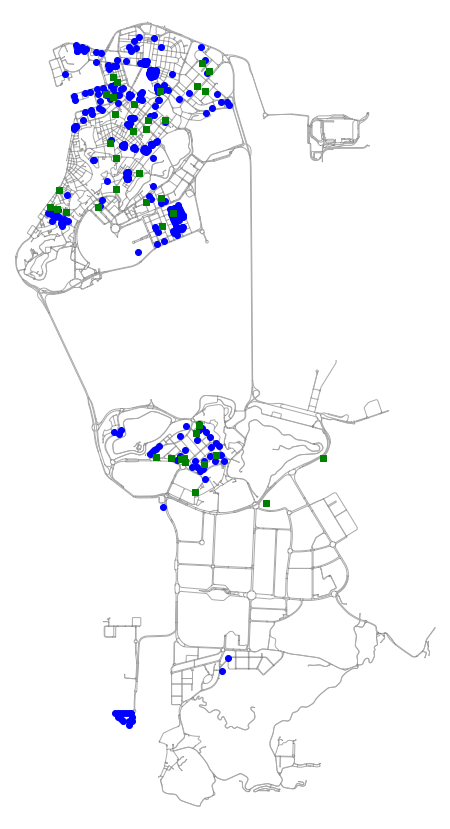

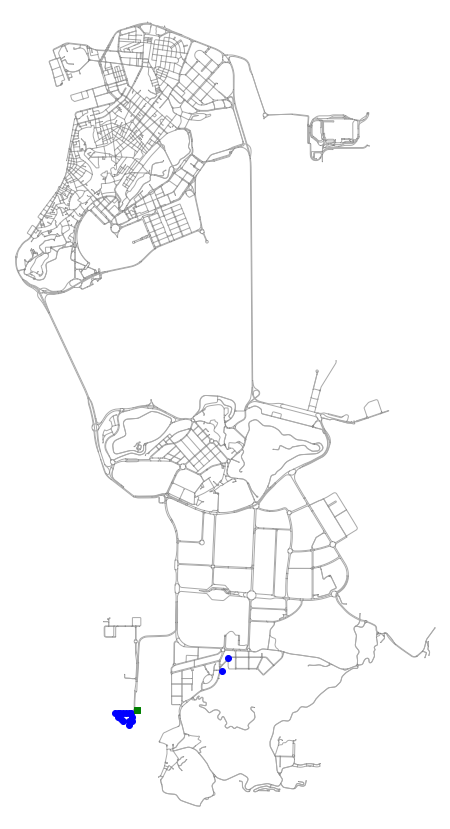

In [11]:
Build711MethodB(place='Macau')

# Method C

In this method, we use sqrt(x*x+y*y) to approximate the distance between 711 and buildings.

In [12]:
import math

In [13]:
def one_epoch_approximate(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings, learn_last=False, node_new=0, node_new_x=0, node_new_y=0):
    if not learn_last:
        K = len(node_seven_elevens)
    else:
        K = len(node_seven_elevens) + 1
    dist = np.zeros(K)
    number = np.zeros(K)
    neighbors = [[] for i in range(0, K)]
    for n, neighbor in enumerate(node_buildings):
        cloest_l = -1
        cloest_k = -1
        for k in range(0, K):
            if not learn_last or k < K - 1:
                center = node_seven_elevens[k]
                center_x = all_seven_elevens["center"][k].x
                center_y = all_seven_elevens["center"][k].y
            else:
                center = node_new
                center_x = node_new_x
                center_y = node_new_y
            # print("K, N", k, center)
            l = math.sqrt(math.pow(center_x - all_buildings["center"][n].x, 2) + math.pow(center_y - all_buildings["center"][n].y, 2))
            if cloest_k == -1 or l < cloest_l:
                cloest_k = k
                cloest_l = l
        if cloest_k != -1:
            # dist
            dist[cloest_k] += cloest_l
            # number
            number[cloest_k] += 1
            # neighbors
            neighbors[cloest_k].append(n)        
    return dist, number, neighbors

In [14]:
def Find711approximate(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings):
    # prepare training
    num_K = len(all_seven_elevens)+1
    num_N = len(all_buildings)
    print("num_K:", num_K)
    print("num_N:", num_N)
    nn = random.randint(0, len(node_buildings) - 1)
    node_new = node_buildings[nn]
    node_new_x = all_buildings['center'][nn].x
    node_new_y = all_buildings['center'][nn].y
    print("node_new", node_new)
    
    # training
    decided = False
    for i in range(5):
        dist, number, neighbors = one_epoch_approximate(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings, learn_last=True, node_new=node_new, node_new_x=node_new_x, node_new_y=node_new_y)
        avg_dist = (dist+0) / (number+1)  # include self
        print("len(dist), dist.mean()", len(dist[number != 0]), dist[number != 0].mean())    
        print("avg_dist max", np.argmax(avg_dist), avg_dist.max())

        # check whether new location is effective
        neighbors_new = neighbors[-1]
        dist_new = dist[-1]
        avg_dist_new = avg_dist[-1]
        number_new = number[-1]
        print("dist_new avg_dist_new number_new", dist_new, avg_dist_new, number_new)
        # if len(neighbors_new) == 0:
        if not decided:
            decided = True
            print("*"*50)
            # if have not got an effective new location for 711, we locate it near by the most busy 711
            neighbors_busy = neighbors[np.argmax(avg_dist)]
            neighbor_new = neighbors_busy[random.randint(0, len(neighbors_busy) - 1)]
            node_new_x = all_buildings['center'][neighbor_new].x
            node_new_y = all_buildings['center'][neighbor_new].y
            node_new = node_buildings[neighbor_new]
        else:
            print("-"*50)
            # if have got an effective new location for 711, we refine its location by k means
            node_new_x = np.mean(all_buildings['center'][neighbors_new].x)
            node_new_y = np.mean(all_buildings['center'][neighbors_new].y)
            node_new = ox.distance.nearest_nodes(G,X=node_new_x,Y=node_new_y)
        print("node_new", node_new)
        
    # visulization
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    ax.scatter(
        node_new_x,   
        node_new_y,   
        c='g',    
        marker="s",
        alpha=1,
        zorder=4
    )
    ax.scatter(
        all_buildings['center'][neighbors[num_K -1]].x, 
        all_buildings['center'][neighbors[num_K -1]].y, 
        c='blue',            
        alpha=1,
        zorder=3
    )
    return node_new, node_new_x, node_new_y

In [15]:
import time
def Build711MethodC(place='Macau'):
    # get data
    G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings = get_seven_elevens_buildings(place)
    plot_seven_elevens_buildings(G, all_seven_elevens,all_buildings)
    
    start_time = time.time()
    node_new, node_new_x, node_new_y = Find711approximate(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings)
    end_time = time.time()

    # metric
    print("-"*50, node_seven_elevens)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("before: total dist", np.sum(dist))
    node_seven_elevens.append(node_new)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("after total dist", np.sum(dist))
    print("Time cost", end_time - start_time)

2022-05-21 00:28:35 Configured OSMnx 1.1.2
2022-05-21 00:28:35 HTTP response caching is on
2022-05-21 00:28:35 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-21 00:28:35 Created GeoDataFrame with 1 rows from 1 queries
2022-05-21 00:28:35 Constructed place geometry polygon(s) to query API
2022-05-21 00:28:35 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:28:35 Projected GeoDataFrame to epsg:4326
2022-05-21 00:28:35 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:28:35 Projected GeoDataFrame to epsg:4326
2022-05-21 00:28:35 Requesting data within polygon from API in 1 request(s)
2022-05-21 00:28:35 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-21 00:28:35 Got all network data within polygon from API in 1 request(s)
2022-05-21 00:28:35 Creating graph from downl

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:28:35 Created graph with 23498 nodes and 29564 edges
2022-05-21 00:28:35 Added length attributes to graph edges
2022-05-21 00:28:35 Identifying all nodes that lie outside the polygon...
2022-05-21 00:28:36 Created nodes GeoDataFrame from graph
2022-05-21 00:28:36 Created r-tree spatial index for 23498 geometries
2022-05-21 00:28:37 Identified 22820 geometries inside polygon
2022-05-21 00:28:37 Removed 678 nodes outside polygon
2022-05-21 00:28:37 Truncated graph by polygon
2022-05-21 00:28:37 Begin topologically simplifying the graph...
2022-05-21 00:28:37 Identified 3456 edge endpoints
2022-05-21 00:28:37 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-21 00:28:37 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-05-21 00:28:37 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-05-21 00:28:37 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-05-21 00:28:37 Found 2 edges between 1832146673

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-21 00:28:38 Created r-tree spatial index for 649 geometries
2022-05-21 00:28:38 Identified 631 geometries inside polygon
2022-05-21 00:28:38 18 geometries removed by the polygon filter
2022-05-21 00:28:38 308 geometries removed by the tag filter
2022-05-21 00:28:38 323 geometries in the final GeoDataFrame
2022-05-21 00:28:38 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-21 00:28:38 Created GeoDataFrame with 1 rows from 1 queries
2022-05-21 00:28:38 Constructed place geometry polygon(s) to query API
2022-05-21 00:28:38 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-21 00:28:38 Projected GeoDataFrame to epsg:4326
2022-05-21 00:28:38 Requesting data within polygon from API in 1 request(s)
2022-05-21 00:28:38 Retrieved response from cache file "cache/3208062aa142b9258b63ba1b19931f64befd9f55.json"
2022-05-21 00:28:38 Got all geometries data within polygon from API in 1 requ

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:28:39 Created nodes GeoDataFrame from graph
2022-05-21 00:28:39 Finished plotting the graph
num_K: 41
num_N: 306
node_new 4598093050
len(dist), dist.mean() 39 0.027623852879264044
avg_dist max 9 0.028351767779808558
dist_new avg_dist_new number_new 0.031087684876394735 0.002391360375107287 12.0
**************************************************
node_new 2492640216
len(dist), dist.mean() 38 0.01759095869920336
avg_dist max 33 0.004295084527030347
dist_new avg_dist_new number_new 0.048512555337328206 0.0028536797257251887 16.0
--------------------------------------------------
2022-05-21 00:28:40 Created nodes GeoDataFrame from graph
node_new 2492640188
len(dist), dist.mean() 38 0.017848278981601955
avg_dist max 33 0.004295084527030347
dist_new avg_dist_new number_new 0.05829072606847499 0.0034288662393220583 16.0
--------------------------------------------------
node_new 2492640188
2022-05-21 00:28:41 Created nodes GeoDataFrame from graph
len(dist), dist.mean() 38 0.01784

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-21 00:28:43 Created nodes GeoDataFrame from graph
2022-05-21 00:28:43 Finished plotting the graph
-------------------------------------------------- [2169023906, 6040835453, 5543335567, 2157625970, 2027444154, 1793358410, 9004853901, 2486214926, 1867326940, 1846288224, 1754036977, 1758262871, 1754056425, 1754056421, 9519277096, 1754036975, 1937893684, 1941039624, 1942400761, 1942810205, 3536417231, 2168717760, 3121609540, 6308719038, 1846266736, 3121665344, 1942810197, 1449241485, 1449241483, 1846195341, 3355823826, 3109979756, 5105836446, 1809540500, 6361766988, 1942467224, 1937893685, 1754056408, 9026600201, 1938179570]
before: total dist 2429.0
after total dist 2093.0
Time cost 4.148662805557251


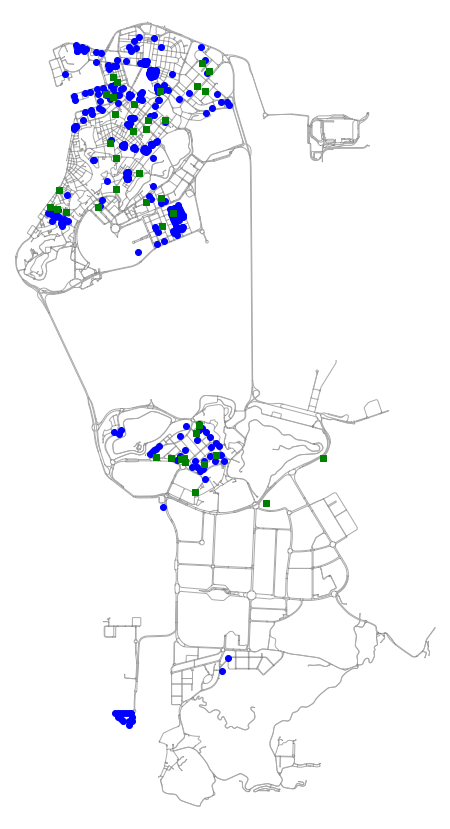

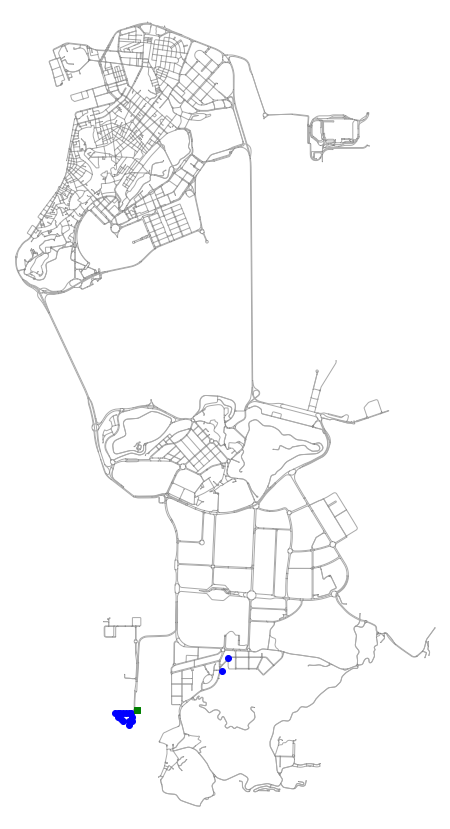

In [16]:
Build711MethodC(place='Macau')

# Method D

In this method, we calculaite hotmap to solve this problem.


In [18]:
from keplergl import KeplerGl
from libkdv import kdv
from time import time
from libkdv.demo import *
import pandas as pd

/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/libkdv/libkdv.dll
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/libkdv/libkdv_mac.dll
/home/huangyuming/anaconda3/envs/libkdv/lib/python3.9/site-packages/libkdv/libkdv_mac_M1.dll


NameError: name 'rapid_kdv_C_library' is not defined

In [ ]:
import time
def Build711MethodD(place='Macau'):
    # get data
    G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings = get_seven_elevens_buildings(place)
    plot_seven_elevens_buildings(G, all_seven_elevens,all_buildings)
    
    start_time = time.time()
    node_new, node_new_x, node_new_y = Find711approximate(G, all_seven_elevens, node_seven_elevens,all_buildings, node_buildings)
    end_time = time.time()

    # metric
    print("-"*50, node_seven_elevens)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("before: total dist", np.sum(dist))
    node_seven_elevens.append(node_new)
    dist, number, neighbors = one_epoch(G, node_seven_elevens, node_buildings)
    print("after total dist", np.sum(dist))
    print("Time cost", end_time - start_time)